**Settings**

In [143]:
#import librosa
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import librosa.display
#import keras
#import datetime
#import seaborn as sns
#from sklearn.preprocessing import LabelEncoder 
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import classification_report

#plt.style.use('ggplot')
#plt.rcParams['font.family'] = 'sans-serif' 
#plt.rcParams['font.serif'] = 'Ubuntu' 
#plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
#plt.rcParams['font.size'] = 14 
#plt.rcParams['axes.labelsize'] = 12 
#plt.rcParams['axes.labelweight'] = 'bold' 
#plt.rcParams['axes.titlesize'] = 12 
#plt.rcParams['xtick.labelsize'] = 12 
#plt.rcParams['ytick.labelsize'] = 12 
#plt.rcParams['legend.fontsize'] = 12 
#plt.rcParams['figure.titlesize'] = 12 
#plt.rcParams['image.cmap'] = 'jet' 
#plt.rcParams['image.interpolation'] = 'none' 
#plt.rcParams['figure.figsize'] = (10, 10) 
#plt.rcParams['axes.grid']=False
#plt.rcParams['lines.linewidth'] = 2 
#plt.rcParams['lines.markersize'] = 8
#colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
#'xkcd:scarlet']
#bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)"""

In [180]:
#requisits and ignore warnings
import warnings
warnings.simplefilter('ignore')

import fnmatch
import collections
import keras
import librosa
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import models, layers
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot, cm
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

In [181]:
# y,sr = librosa.load('audios/Speaker26_000.wav')
# dur_time = librosa.get_duration(y=y,sr=sr)
#print(dur_time)
#time_sec = round(dur_time)
#S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=20, fmax=8000)
#fig, ax = plt.subplots()
#S_dB = librosa.power_to_db(S, ref=np.max)
#img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000, ax=ax)
#fig.colorbar(img, ax=ax, format='%+2.0f dB')
#ax.set(title='Mel-frequency spectrogram')
#plt.xlim()"""

In [182]:
#time_series_sec=np.linspace(0, time_sec, len(S_dB[0]))

The output of this section is the CSV files with the data to be handle by the model

```
trainData     : audio/train 
testData      : audio/test
```


In [183]:
# Defines the names of the CSV files
TRAIN_CSV_FILE = "train.csv"
TEST_CSV_FILE = "test.csv"
final_test="final_test.csv"

In [184]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import librosa
import csv
import os
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')

def extractWavFeatures(soundFilesFolder, csvFileName):
    print("The features of the files in the folder "+soundFilesFolder+" will be saved to "+csvFileName)
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    print('CSV Header: ', header)
    file = open(csvFileName, 'w', newline='')
    #with file:
    writer = csv.writer(file)
    writer.writerow(header)
    count=0
    for filename in tqdm(os.listdir(soundFilesFolder)):
        number = f'{soundFilesFolder}/{filename}'
        y, sr = librosa.load(number, mono=True)
        # remove leading and trailing silence
        y, index = librosa.effects.trim(y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        writer.writerow(to_append.split())
    file.close()
    print("End of extractWavFeatures")
    

### Train

from pathlib import Path
import os

for folder in tqdm(os.listdir("audios/audios/56_speakers_audio_data")):
    if ".sh" not in folder:
        os.makedirs("audios/audios/data/"+folder)
        for file in tqdm(os.listdir("audios/audios/56_speakers_audio_data/"+folder)):
            audio, sr = librosa.load('audios/audios/56_speakers_audio_data/'+folder+"/"+file)
            audio, index = librosa.effects.trim(audio)
            buffer = sr * 10 #10s

            samples_total=len(audio)
            samples_wrote=0
            counter =1
            while samples_wrote<samples_total:
                if buffer > (samples_total - samples_wrote):
                    buffer = samples_total - samples_wrote
                block = audio[samples_wrote : (samples_wrote + buffer)]
                out_filename="audios/audios/data/"+folder+"/"+str(counter)+"_"+file
                sf.write(out_filename, block, sr)
                counter+=1
                samples_wrote += buffer

import soundfile as sf
audio, sr = librosa.load('audios/audios/56_speakers_audio_data/Speaker0000/Speaker0000_000.wav')
audio, index = librosa.effects.trim(audio)
buffer = sr * 10 #10s

samples_total=len(audio)
samples_wrote=0
counter =1
while samples_wrote<samples_total:
    if buffer > (samples_total - samples_wrote):
        buffer = samples_total - samples_wrote
    block = audio[samples_wrote : (samples_wrote + buffer)]
    out_filename="/audios/audios/data/"+str(counter)+".wav"
    sf.write(out_filename, block, sr)
    counter+=1
    samples_wrote += buffer


In [185]:
#extractWavFeatures("new_audios/train", TRAIN_CSV_FILE)
#extractWavFeatures("new_audios/test", TEST_CSV_FILE)
extractWavFeatures("audios/audios/train", TRAIN_CSV_FILE)
print("CSV files are created")

The features of the files in the folder audios/audios/train will be saved to train.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14148/14148 [25:02<00:00,  9.42it/s]

End of extractWavFeatures
CSV files are created


In [186]:
extractWavFeatures("audios/audios/test", TEST_CSV_FILE)

The features of the files in the folder audios/audios/test will be saved to test.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3586/3586 [04:21<00:00, 13.71it/s]

End of extractWavFeatures


In [187]:
import pandas as pd
import csv
from sklearn import preprocessing

def preProcessData(csvFileName):
    print(csvFileName+ " will be preprocessed")
    data = pd.read_csv(csvFileName)
    filenameArray = data['filename'] 
    speakerArray = []
    #print(filenameArray)
    for i in range(len(filenameArray)):
        speaker = int(filenameArray[i].split("_")[0].split("r")[1])
        if(speaker<61 or speaker==62):
           speaker=0
        else:
           speaker=speaker-60
           print(speaker)
           print(filenameArray[i])
        speakerArray.append(speaker)
    data['number'] = speakerArray
    #Dropping unnecessary columns
    data = data.drop(['filename'],axis=1)
    data = data.drop(['label'],axis=1)
    data = data.drop(['chroma_stft'],axis=1)
    data.shape

    print("Preprocessing is finished")
    print(data.head())
    return data



In [188]:
trainData = preProcessData(TRAIN_CSV_FILE)

testData = preProcessData(TEST_CSV_FILE)
pd.DataFrame(trainData).to_parquet("train.parquet")
pd.DataFrame(testData).to_parquet("test.parquet")
print(trainData)
#print(testData.shape)

train.csv will be preprocessed
1
Speaker0061_002.wav
1
Speaker0061_012.wav
1
Speaker0061_008.wav
1
Speaker0061_005.wav
1
Speaker0061_000.wav
1
Speaker0061_010.wav
1
Speaker0061_011.wav
1
Speaker0061_014.wav
1
Speaker0061_007.wav
1
Speaker0061_013.wav
1
Speaker0061_003.wav
1
Speaker0061_004.wav
1
Speaker0061_015.wav
1
Speaker0061_009.wav
1
Speaker0061_001.wav
1
Speaker0061_006.wav
Preprocessing is finished
       rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0  0.042311        2853.672685         2439.693251  5226.797861   
1  0.066338        2483.207666         2219.299281  4473.985089   
2  0.066239        1958.893779         1379.487170  3135.079496   
3  0.028860        2084.254664         1733.049552  3707.682839   
4  0.022163        2422.857641         2228.497802  4738.079083   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  \
0            0.167396 -292.636353   77.443962 -14.946343   3.072196   
1            0.149599 -293.354309   83.380547 

array([[<AxesSubplot: title={'center': 'rmse'}>,
        <AxesSubplot: title={'center': 'spectral_centroid'}>,
        <AxesSubplot: title={'center': 'spectral_bandwidth'}>,
        <AxesSubplot: title={'center': 'rolloff'}>,
        <AxesSubplot: title={'center': 'zero_crossing_rate'}>],
       [<AxesSubplot: title={'center': 'mfcc1'}>,
        <AxesSubplot: title={'center': 'mfcc2'}>,
        <AxesSubplot: title={'center': 'mfcc3'}>,
        <AxesSubplot: title={'center': 'mfcc4'}>,
        <AxesSubplot: title={'center': 'mfcc5'}>],
       [<AxesSubplot: title={'center': 'mfcc6'}>,
        <AxesSubplot: title={'center': 'mfcc7'}>,
        <AxesSubplot: title={'center': 'mfcc8'}>,
        <AxesSubplot: title={'center': 'mfcc9'}>,
        <AxesSubplot: title={'center': 'mfcc10'}>],
       [<AxesSubplot: title={'center': 'mfcc11'}>,
        <AxesSubplot: title={'center': 'mfcc12'}>,
        <AxesSubplot: title={'center': 'mfcc13'}>,
        <AxesSubplot: title={'center': 'mfcc14'}>,
   

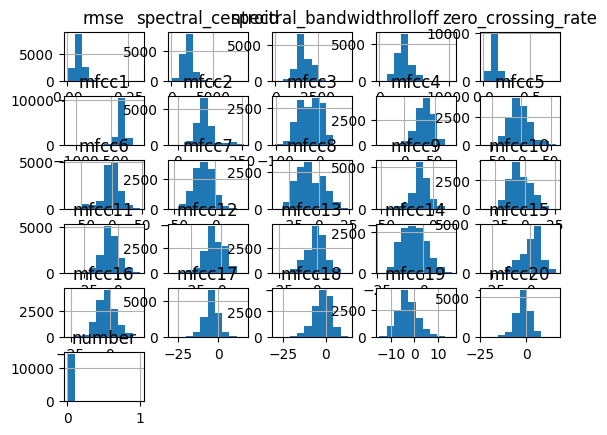

In [189]:
trainData.hist()


In [190]:
groupby_gender.boxplot(column=['G3'],meanline=False,showmeans=True,return_type='dict')

NameError: name 'groupby_gender' is not defined

In [191]:
# Splitting the dataset into training, validation and testing dataset
from sklearn.model_selection import train_test_split
X = np.array(trainData.iloc[:, :-1], dtype = float)
y = trainData.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=50)


X_test = np.array(testData.iloc[:, :-1], dtype = float)
y_test = testData.iloc[:, -1]
print(set(y_train))

print("Y from training data:", y_train.shape)
print("Y from validation data:", y_val.shape)
print("Y from test data:", y_test.shape)


{0, 1}
Y from training data: (9903,)
Y from validation data: (4245,)
Y from test data: (3586,)


In [192]:
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_val = scaler.transform( X_val )
X_test = scaler.transform( X_test )

print("X from training data", X_train.shape)
print("X from validation data", X_val.shape)
print("X from test data", X_test.shape)


X from training data (9903, 25)
X from validation data (4245, 25)
X from test data (3586, 25)


In [193]:
print([y_train])

[8813     0
6886     0
13549    0
9965     0
12232    0
        ..
10206    0
6253     0
10123    0
5600     0
14000    0
Name: number, Length: 9903, dtype: int64]


In [194]:
print(X_train.shape)
print(y_train.shape)
test=np.concatenate([X_train, np.array(y_train).reshape((len(y_train), 1))], axis = 1)
print(test.shape)

(9903, 25)
(9903,)
(9903, 26)


0.0         AxesSubplot(0.1,0.15;0.363636x0.75)
1.0    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

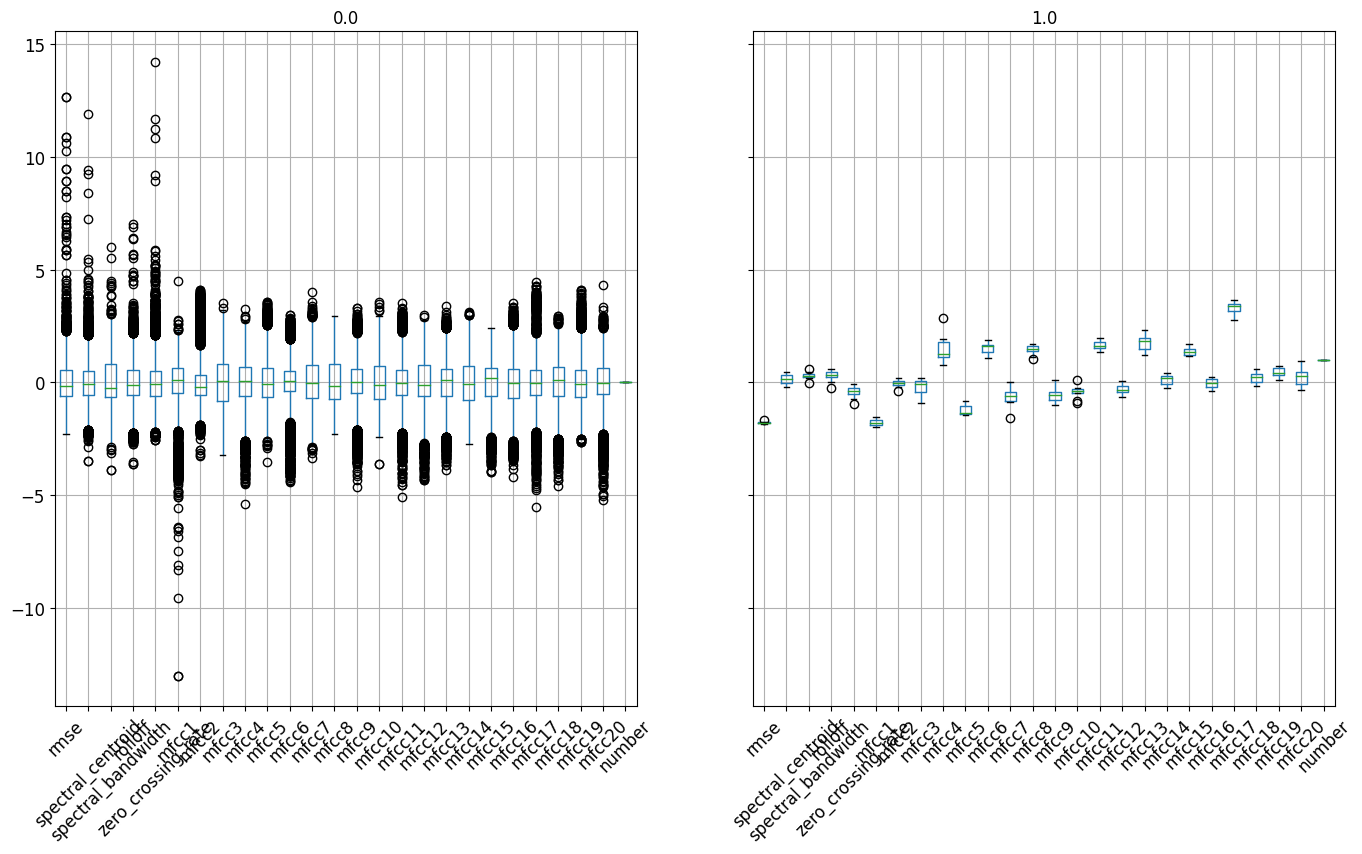

In [195]:
groupby_user = pd.DataFrame(data=test, columns=trainData.columns).groupby('number')
groupby_user.boxplot(rot=45, fontsize=12, figsize=(16,9))

In [196]:
import os
import fnmatch
import collections
weight={}
total=0
path='audios/audios/56_speakers_audio_data'
for speaker in os.listdir(path):
    if speaker.find(".sh")==-1:
        dir_path=path+'/'+speaker
        speaker = int(speaker.split("_")[0].split("r")[1])
        if(speaker<60):
            speaker = 0
            total = total+int(len(fnmatch.filter(os.listdir(dir_path), '*.*'))*0.8)-1

        else:
            speaker= speaker-60
        count = int(len(fnmatch.filter(os.listdir(dir_path), '*.*'))*0.8)-1
        weight.update({speaker: count})
weight.update({0:total})
max_value=sum(weight.values())
print("Sum of values: "+str(max_value))
weight = {key: value for key, value in sorted(weight.items())}
print(weight)
class_weight = {k: 1-(v/max_value) for k, v in weight.items()}
print(class_weight)
#print(set(range(57)) - set(y_train))

Sum of values: 3265
{0: 3235, 1: 15, 2: 15}
{0: 0.009188361408882129, 1: 0.9954058192955589, 2: 0.9954058192955589}


In [197]:
len(y_train)

9903

dump (parquet--> data train and test)
scaler

weight={0:15, 1:42}

max_value=sum(weight.values())
print("Sum of values: "+str(max_value))
weight = {key: value for key, value in sorted(weight.items())}
print(weight)
class_weight = {k: (1-(v/max_value))*100 for k, v in weight.items()}
print(class_weight)

In [224]:
len(y_val)

4245

In [234]:
#Creating a Model
from keras import models
from keras import layers
import keras

class_weight={0: 0.5005054078641463, 1: 495.15000000000003}

# model 1
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Learning Process of a model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# simple early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1)
#es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
print(X_train.shape)
#Train with early stopping to avoid overfitting
y_train=np.array(y_train, dtype=int)
y_val=np.array(y_val, dtype=int)
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),epochs=100,batch_size=128, class_weight=class_weight, callbacks=[es])
print(set(y_test))

(9903, 25)
Epoch 1/100
78/78 [==============================] - 1s 3ms/step - loss: 0.5074 - accuracy: 0.9697 - val_loss: 0.0313 - val_accuracy: 1.0000
Epoch 2/100
78/78 [==============================] - 0s 2ms/step - loss: 0.1400 - accuracy: 0.9981 - val_loss: 0.0144 - val_accuracy: 1.0000
Epoch 3/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0447 - accuracy: 0.9987 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 4/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0400 - accuracy: 0.9990 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 5/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0200 - accuracy: 0.9994 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 6/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 7/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Ep

In [235]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                1664      
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,889
Trainable params: 5,889
Non-trainable params: 0
_________________________________________________________________


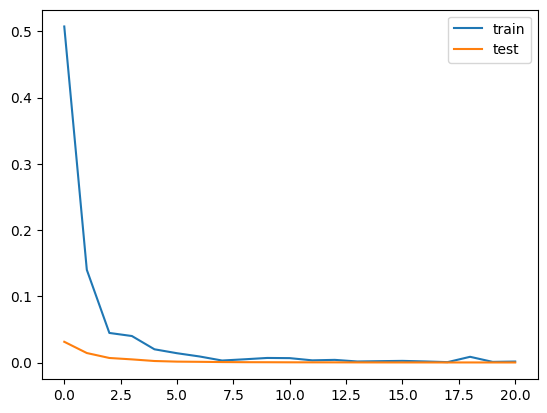

In [236]:
# plot training history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [237]:
def getSpeaker(speaker):
    speaker = "Speaker"+str(speaker).zfill(3)
    return speaker
    
        
def printPrediction(X_data, y_data, printDigit, model):
    print('\n# Generate predictions')
    for i in range(len(y_data)):
        predict_x=model.predict(X_data[i:i+1])[0]
        predict_classes = np.argmax(predict_x)
        print(predict_classes)
        print(max(predict_x))
        prediction = getSpeaker(predict_classes)
    
        speaker = getSpeaker(y_data[i])
        if printDigit == True:
           print("Number={0:d}, y={1:10s}- prediction={2:10s}- match={3}".format(i, speaker, prediction, speaker==prediction))
        else:
           print("y={0:10s}- prediction={1:10s}- match={2}".format(speaker, prediction, speaker==prediction))

In [238]:
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

def report(X_data, y_data):
    #Confution Matrix and Classification Report
    predict_y = model.predict(X_data)
    Y_pred = np.argmax(predict_y, axis=1)
    y_test_num = y_data.astype(np.int64)
    conf_mt = confusion_matrix(y_test_num, Y_pred)
    print(conf_mt[len(set(y_test_num))-1])
    key=0
    for val in conf_mt[len(set(y_test_num))-1]:
        if val!=0:
            print(key)
        key=key+1
    conf_mt=conf_mt / conf_mt.astype(np.float).sum(axis=1)
    #print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    print(classification_report(y_test_num, Y_pred))


In [239]:
print(y_test)

[0 0 0 ... 0 0 0]


In [240]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [241]:
print('\n# TEST DATA #\n')
y_test=np.array(y_test, dtype=int)
score = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
# Prediction
#printPrediction(X_test, y_test, False, model)


# TEST DATA #

113/113 [==============================] - 0s 679us/step - loss: 0.0682 - accuracy: 0.9936
accuracy: 99.36%


Classification Report for Test Data

(3586,)
(3586, 25)
113/113 [==============================] - 0s 586us/step
[24  0]
0


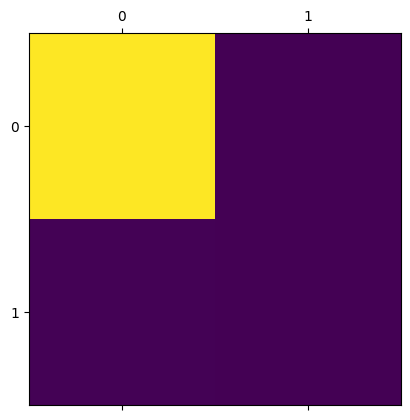


Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3562
           1       0.00      0.00      0.00        24

    accuracy                           0.99      3586
   macro avg       0.50      0.50      0.50      3586
weighted avg       0.99      0.99      0.99      3586



In [242]:
print("Classification Report for Test Data\n")
print(y_test.shape)
print(X_test.shape)
report(X_test, y_test)

### Save model

In [198]:
import joblib
model.save('speaker-recognition.h5')
joblib.dump(scaler, 'scaler.save') 

['scaler.save']


Transfer learning

https://keras.io/guides/transfer_learning/


### Load model



def preProcessData(csvFileName):
    data = pd.read_csv(csvFileName)
    filenameArray = data['filename'] 
    speakerArray = []
    #print(filenameArray)
    for i in range(len(filenameArray)):
        speaker = int(filenameArray[i].split("_")[0].split("r")[1])
        speakerArray.append(speaker)
    data['number'] = speakerArray
    #Dropping unnecessary columns
    data = data.drop(['filename'],axis=1)
    data = data.drop(['label'],axis=1)
    data = data.drop(['chroma_stft'],axis=1)
    data.shape
    return data


def getSpeaker(speaker):
    speaker = "Speaker"+str(speaker).zfill(3)
    return speaker
    
        
def printPrediction(X_data, y_data, printDigit, model):
    print('\n# Generate predictions')
    for i in range(len(y_data)):
        predict_x=model.predict(X_data[i:i+1])[0]
        predict_classes = np.argmax(predict_x)
        prediction = getSpeaker(predict_classes)
    
        speaker = getSpeaker(y_data[i])
        if printDigit == True:
           print("Number={0:d}, y={1:10s}- prediction={2:10s}- match={3}".format(i, speaker, prediction, speaker==prediction))
        else:
           print("y={0:10s}- prediction={1:10s}- match={2}".format(speaker, prediction, speaker==prediction))

In [2]:
def extractWavFeatures(filename, csvFileName):
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file = open(csvFileName, 'w', newline='')
    #with file:
    writer = csv.writer(file)
    writer.writerow(header)
    number = f'new_audios/test_file/{filename}'
    y, sr = librosa.load(number, mono=True, duration=30)
    # remove leading and trailing silence
    y, index = librosa.effects.trim(y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    rmse = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
    for e in mfcc:
        to_append += f' {np.mean(e)}'
    writer.writerow(to_append.split())
    file.close()
    

In [13]:
def predict_audio(filename):
    extractWavFeatures(filename, final_test)
    final_testData = preProcessData(final_test)
    
    X_test = np.array(final_testData.iloc[:, :-1], dtype = float)
    y_test = final_testData.iloc[:, -1]
    
    X_test = scaler.transform( X_test )
    #y_test=np.array(y_test, dtype=int)
    
    score = new_model.evaluate(X_test, y_test)
    # Prediction
    printPrediction(X_test, y_test, False, new_model)
    print(y_test)

In [15]:
from keras import models
from keras import layers
import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import os
import librosa
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import joblib
import csv


final_test="final_test.csv"
new_model = keras.models.load_model('speaker-recognition.h5')
scaler = joblib.load('scaler.save') 

predict_audio("Speaker0061_000.wav")


final_test.csv will be preprocessed
Preprocessing is finished
       rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0  0.007787        1842.464876         1743.385975  3579.227668   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  \
0            0.107789 -444.994324  125.452003 -33.564625  43.520443   

       mfcc5  ...     mfcc12    mfcc13   mfcc14    mfcc15    mfcc16    mfcc17  \
0 -27.101084  ... -11.397572  3.390763 -7.57964  9.951971 -2.636461  6.408022   

     mfcc18    mfcc19    mfcc20  number  
0 -6.711493  1.017713  2.169574      61  

[1 rows x 26 columns]
1/1 [==============================] - 0s 105ms/step - loss: 0.0753 - accuracy: 1.0000

# Generate predictions
1/1 [==============================] - 0s 45ms/step
61
0.9274281
y=Speaker061- prediction=Speaker061- match=True
0    61
Name: number, dtype: int64


### Register


In [ ]:
TRAIN_CSV_FILE = "train.csv"
NEW_USER = "new_user.csv"
extractWavFeatures("new_audios/train", NEW_USER)


In [ ]:
dataFrame = pd.read_csv(NEW_USER)
dataFrame.to_csv(TRAIN_CSV_FILE, mode='a', index=False, header=False)

In [ ]:
trainData = preProcessData(TRAIN_CSV_FILE)
# Splitting the dataset into training, validation and testing dataset
from sklearn.model_selection import train_test_split
X = np.array(trainData.iloc[:, :-1], dtype = float)
y = trainData.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=50)

print("Y from training data:", y_train.shape)
print("Y from validation data:", y_val.shape)


In [ ]:
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_val = scaler.transform( X_val )

print("X from training data", X_train.shape)
print("X from validation data", X_val.shape)


In [ ]:
#Creating a Model
from keras import models
from keras import layers
import keras

# model 1
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(y_train), activation='softmax'))

# Learning Process of a model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# simple early stopping
from keras.callbacks import EarlyStopping
#es = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
print(X_train.shape)
#Train with early stopping to avoid overfitting
y_train=np.array(y_train, dtype=int)
y_val=np.array(y_val, dtype=int)
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),epochs=100,batch_size=1, callbacks=[es])
print(set(y_train))

In [ ]:
testData = preProcessData(TEST_CSV_FILE)

X_test = np.array(testData.iloc[:, :-1], dtype = float)
y_test = testData.iloc[:, -1]
print(set(y_test))

X_test = scaler.transform( X_test )
print("X from test data", X_test.shape)

print(set(y_test))
print("Y from test data:", y_test.shape)


In [ ]:
print('\n# TEST DATA #\n')
y_test=np.array(y_test, dtype=int)
score = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
# Prediction
printPrediction(X_test, y_test, False, model)

In [ ]:
print("Classification Report for Test Data\n")
print(y_test.shape)
print(X_test.shape)
report(X_test, y_test)